In [ ]:
result_data = json.load(open('./results/sgcls/test_predict.json'))


In [26]:
index = 600
display(result_data[index]['hyp'][0])
display(result_data[index]['img_id'])

[['man', 'wearing', 'jacket'],
 ['man', 'wearing', 'pant'],
 ['man', 'wearing', 'pant'],
 ['man', 'on', 'snow'],
 ['man', 'wearing', 'jacket', 'jacket'],
 ['person', 'wearing', 'jacket', 'jacket'],
 ['track', 'in', 'snow', 'snow'],
 ['skier', 'in', 'snow']]

'2342980'

In [24]:
import json
import requests
from io import BytesIO
import h5py
from PIL import Image

img_data_dict = json.load(open('/data/hulab/zcai75/visual_genome/vg_motif_anno/image_data.json'))
idx_by_id = {img_data['image_id']: i for i, img_data in enumerate(img_data_dict)}
j=idx_by_id[int(result_data[index]['img_id'])]
img_data = img_data_dict[j]
raw = requests.get(img_data['url']).content
image = Image.open(BytesIO(raw))

ann = h5py.File('/data/hulab/zcai75/visual_genome/vg_motif_anno/VG-SGG-with-attri.h5', 'r')
label_data = json.load(open('/data/hulab/zcai75/visual_genome/vg_motif_anno/VG-SGG-dicts-with-attri.json'))
first_rel = ann['img_to_first_rel'][j]
last_rel = ann['img_to_last_rel'][j]
img_rels = ann['relationships'][first_rel : last_rel+1]
box1_ids = [ann['labels'][i][0] for i in img_rels[:, 0]]
box2_ids = [ann['labels'][i][0] for i in img_rels[:, 1]]
pred_ids = ann['predicates'][first_rel : last_rel+1]
pred_label = [label_data['idx_to_predicate'][str(i[0])].encode('utf-8') for i in pred_ids]
box1_label = [label_data['idx_to_label'][str(i)].encode('utf-8') for i in box1_ids]
box2_label = [label_data['idx_to_label'][str(i)].encode('utf-8') for i in box2_ids]
max_image_size = max(image.size)

display(list(zip(box1_label, pred_label, box2_label)))


[(b'snow', b'covering', b'mountain'),
 (b'snow', b'on', b'roof'),
 (b'roof', b'of', b'building'),
 (b'railing', b'of', b'building'),
 (b'pant', b'of', b'skier'),
 (b'skier', b'holding', b'pole'),
 (b'person', b'holding', b'pole'),
 (b'person', b'using', b'ski'),
 (b'person', b'on', b'ski'),
 (b'people', b'on', b'snow'),
 (b'man', b'wearing', b'pant'),
 (b'snow', b'covering', b'tree'),
 (b'pole', b'on', b'man'),
 (b'snow', b'on', b'roof'),
 (b'roof', b'on', b'building')]

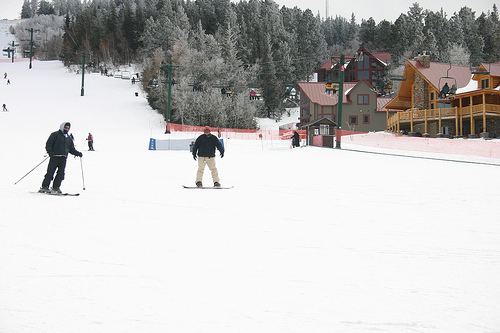

In [25]:
display(image)

In [ ]:
dic = {}
lower = int(box_range.split(',')[0])
box_label = box_label.split(',')
pred_label = pred_label.split(',')
# print(self.dataset[index][:-1])
for i, rel in enumerate(img_rels.split(',')):
    rel = rel.split()
    pred = self.bpe.encode(' {}'.format(pred_label[i]))
    if rel[0] not in dic:
        dic[rel[0]] = {rel[1]: pred}
    else:
        dic[rel[0]][rel[1]] = pred

caption = ""
for r1 in dic:
    l1 = self.bpe.encode(' {}'.format(box_label[int(r1) - lower]))
    caption += "<sub> {} ".format(l1)
    for r2 in dic[r1]:
        l2 = self.bpe.encode(' {}'.format(box_label[int(r2) - lower]))
        caption += "<pred> {} <obj> {} ".format(dic[r1][r2], l2)

# print(caption)